In [2]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def coarse(t):
    return t

def coarse_solver(t, t0, u0):
    return u0 + t - t0

def fine(t):
    return t + np.sin(np.pi/2.0*t)

def exact_solver(t, t0, u0):
    return u0 + t - t0 + np.sin(np.pi/2.0*t) - np.sin(np.pi/2.0*t0)

<IPython.core.display.Javascript object>


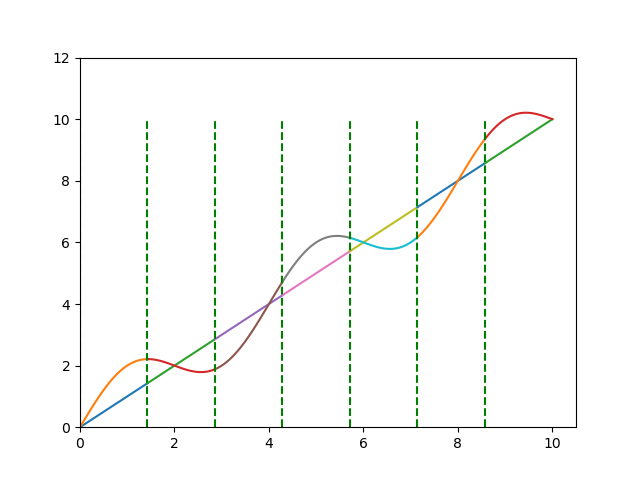

In [4]:
t_range = [0, 10]
N = 7
chunks = np.linspace(t_range[0], t_range[1], N+1)
tt = []
u_coarse = []
u_fine = []

uc_0 = 0
uf_0 = 0

fig0 = plt.figure()
ax = fig0.add_subplot(1,1,1)
ax.set_xlim(0,10.5)
ax.set_ylim(0,12)

fig0.show()
fig0.canvas.draw()

for i in range(N):
    t_current = np.linspace(chunks[i], chunks[i+1], 101)
    uc_current = coarse_solver(t_current, t_current[0], uc_0)
    uf_current = exact_solver(t_current, t_current[0], uf_0)
    
    uc_0 = uc_current[-1]
    uf_0 = uf_current[-1]
    
    tt.append(t_current)
    u_coarse.append(uc_current)
    u_fine.append(uf_current)
    
    plt.plot(t_current, uc_current)
    plt.plot(t_current, uf_current)
    plt.plot(chunks[i]*np.ones(100), np.linspace(0, 10, 100), 'g--')
    fig0.canvas.draw()
    time.sleep(1.5)

In [5]:
def create_variable(size):
    std = np.sqrt(2.0 / size[1])
    return tf.Variable(tf.random_normal(shape=size, stddev=std))

def feed_forward_NN(x, W, b):
    A = x
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(W[i], A), b[i]))
    return tf.add(tf.matmul(W[-1], A), b[-1])

In [6]:
tf.reset_default_graph()

layer_dims = [1] + 3*[16] + [1]
L = len(layer_dims)

Weights = []
Biases = []
for i in range(N):
    W = [create_variable([layer_dims[l], layer_dims[l-1]]) for l in range(1, L)]
    b = [create_variable([layer_dims[l], 1]) for l in range(1, L)]
    Weights.append(W)
    Biases.append(b)
    
T = []
Rhs = []
Tb = []
Bc = []
Loss = []
Train = []
Unn = []
for i in range(N):
    
    t = tf.placeholder(shape=[1,None], dtype=tf.float32)
    u = feed_forward_NN(t, Weights[i], Biases[i])
    u_dt = tf.gradients(u, t)[0]
    rhs = tf.placeholder(shape=[1,None], dtype=tf.float32)
    
    MSE_f = tf.reduce_mean(tf.square(u_dt - rhs))
    
    tb = tf.placeholder(shape=[1,None], dtype=tf.float32)
    ub = feed_forward_NN(tb, Weights[i], Biases[i])
    bc = tf.placeholder(shape=[1,None], dtype=tf.float32)
    
    MSE_b = tf.reduce_mean(tf.square(ub - bc))
    
    loss = MSE_f + MSE_b
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss, var_list=[Weights[i], Biases[i]])
    
    T.append(t)
    Rhs.append(rhs)
    Tb.append(tb)
    Bc.append(bc)
    Loss.append(loss)
    Train.append(train)
    Unn.append(u)

In [7]:
# Training Data
ColPoints = []
Residue = []
for i in range(N):
    t_col = np.linspace(chunks[i], chunks[i+1], 101)
    rhs = 1.0 + np.pi / 2.0 * np.cos(np.pi / 2.0 * t_col)
    ColPoints.append(np.reshape(t_col, [1,-1]))
    Residue.append(np.reshape(rhs, [1, -1]))

In [8]:
def fine_solver(sess, chunk_id, t, t0, u0):
    
    train_dict = {T[chunk_id]: ColPoints[chunk_id],
                 Rhs[chunk_id]: Residue[chunk_id],
                 Tb[chunk_id]: np.reshape(t0, [1,-1]),
                 Bc[chunk_id]: np.reshape(u0, [1,-1])}
    
    num_epoch = 50000
    loss = float('Inf')
    niter = 0
    while loss > 1e-6 and niter < num_epoch:
        niter += 1
        _, loss = sess.run([Train[chunk_id], Loss[chunk_id]], feed_dict=train_dict)
    
    print('Chunk #', chunk_id, ':', niter)
    
    test_dict = {T[chunk_id]: np.reshape(t, [1,-1])}
    u_test = sess.run(Unn[chunk_id], feed_dict=test_dict)
    
    return np.squeeze(u_test)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

<IPython.core.display.Javascript object>


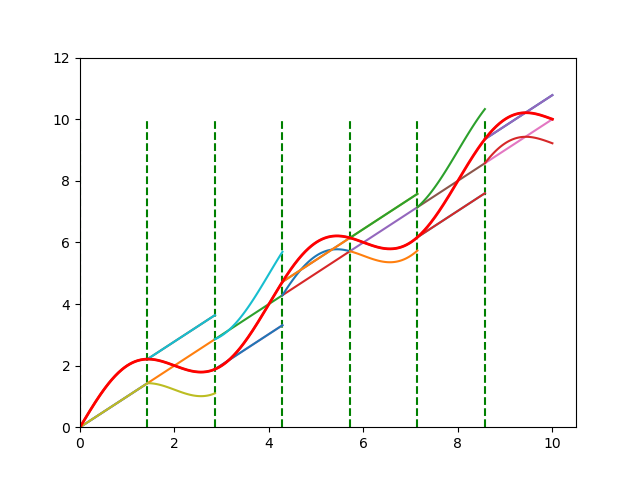

Iteratoin: 1 ;  Error: 40.0
Chunk # 0 : 7724
Chunk # 1 : 10141
Chunk # 2 : 14523
Chunk # 3 : 6164
Chunk # 4 : 16509
Chunk # 5 : 39864
Chunk # 6 : 32266
Iteratoin: 2 ;  Error: 4.381371225629534
Chunk # 0 : 8
Chunk # 1 : 7379
Chunk # 2 : 5432
Chunk # 3 : 742
Chunk # 4 : 8218
Chunk # 5 : 4283
Chunk # 6 : 4133
Iteratoin: 3 ;  Error: 0.0007705688476731254
Awesome! Error converges, iteration terminated.


In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,10.5)
ax.set_ylim(0,12)

for i in range(N):
    plt.plot(chunks[i]*np.ones(101), np.linspace(0, 10, 101), 'g--')

fig.show()
fig.canvas.draw()

# initial condition U(t0) = u0
u0 = 0

U = [u0] + [100 for i in range(N)]
G = [0 for i in range(N)]
F = G.copy()

niter = 0
while niter < N:    
    niter += 1
    
    # coarse solver (serial)
    error = []
    for n in range(N):
        t_current = tt[n]
        uc_current = coarse_solver(t_current, chunks[n], U[n])
        u_coarse[n] = uc_current
        plt.plot(t_current, uc_current)
        fig.canvas.draw()
        time.sleep(1.5)
        
        G_new = uc_current[-1]
        U[n+1] = G_new - G[n] + F[n]
        error += [np.abs(G_new - G[n])]
        G[n] = G_new
        
    # check error
    print('Iteratoin:', niter, ';  Error:', sum(error))
    if sum(error) < 1e-3:
        print('Awesome! Error converges, iteration terminated.')
        break
    
    # fine solver (parallel)
    for n in range(N):
        t_current = tt[n]
        uf_current = fine_solver(sess, n, t_current, chunks[n], U[n])
        u_fine[n] = uf_current
        plt.plot(t_current, uf_current)
        fig.canvas.draw()
        
        F[n] = uf_current[-1]

if niter == N:
    print('Oops! Maximum number of iteration is used.')
    
t_plot = np.concatenate(tt)
uf_plot = np.concatenate(u_fine)
plt.plot(t_plot, uf_plot, 'r-', linewidth=2)
fig.canvas.draw()

In [10]:
sess.close()